# Introduction

Image-to-image translation is a fundamental task in computer vision that focuses on converting an image from one domain into a corresponding image in another. This project explores the use of **Cycle-Consistent Generative Adversarial Networks (CycleGANs)** for translating images between two visually distinct animals: cats and dogs. This tasks is more difficult than translating between two similar animals due to the differences in shape, texture, facial structure, fur patterns and other distinct features between cats and dogs. Unlike traditional methods requiring paired datasets, where an image of a cat is directly matched with an equivalent image of a dog, CycleGANs enable unpaired image-to-image translation, making them a great fit for this project.

The primary objective is to develop a model capable of transforming an image of a cat into an image of a dog, and vice versa, while preserving important attributes such as pose, orientation, and background context. Achieving this requires not only generating realistic textures and colors but also ensuring structural consistency between the input and output images.

For this project, I will utilize the **Kaggle Cats and Dogs dataset**, which provides a large collection of images containing various breeds, poses, lighting conditions, and backgrounds. This dataset introduces real-world variability, challenging the model to generalize across diverse scenarios.

**Project Goals:**

- Preprocessing: Efficiently process and augment the dataset to ensure the model receives high-quality and diverse input images.
- Model Architecture: Implement the CycleGAN framework, which consists of two generators (for cat-to-dog and dog-to-cat translation) and two discriminators (to distinguish real and generated images).
- Training Procedure: Train the CycleGAN using cycle-consistency loss, adversarial loss, and identity loss to ensure stable learning and realistic outputs.
- Evaluation: Assess the model’s performance both qualitatively, through visual inspection of translated images, and quantitatively using appropriate metrics.
- Challenges & Limitations: Address common issues such as mode collapse, training instability, and difficulties in capturing fine-grained details.


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import PIL.Image as Image
import seaborn as sns
import optuna

# Use GPU if available
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.AUTOTUNE

2025-03-02 09:57:52.723711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740934672.841524     939 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740934672.875857     939 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 09:57:53.174048: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


# Data

For this project, I am using the [Kaggle Cat vs Dog Dataset](https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset/data) on Kaggle.

## Overview

The dataset contains a collection of **25,000 images** of cats and dogs, with **12,500 images per class**. Each image varies in size, breed, pose, and lighting conditions, providing a rich and diverse dataset ideal for training deep learning models. Images are named in the format `#.jpg"`, where `#` represents the image index relative to the `Cat` or `Dog` directory.

## Key Features

- **Balanced Classes:** Equal representation of cats and dogs means unbiased training.
- **Diverse Images:** Includes various cat and dog breeds with differences in fur color, texture, and facial structures.
- **Variability in Conditions:** Images come with varying backgrounds, poses, and lighting, enabling the model to generalize to real-world scenarios.
- **High Resolution:** Images are high-quality but will be resized for model compatibility during preprocessing.

## Dataset Structure

The dataset is broken into two directories in the following structure:

- Cat
  - 1.jpg
  - 2.jpg
  - ...
- Dog
  - 1.jpg
  - 2.jpg
  - ...


# Preprocessing

To prepare the dataset for CycleGAN training, the following preprocessing steps will be performed:

1. **Resizing:** Standardize all images to a consistent resolution (e.g., 256x256 pixels).
2. **Normalization:** Scale pixel values to the range [-1, 1] to improve model convergence.
3. **Data Augmentation:** Apply random flips, rotations, and color adjustments to increase dataset diversity and improve model robustness.
4. **Splitting:** Divide the dataset into training and validation sets to monitor model performance and prevent overfitting.


Cat-tfrec TFRecord Files: 1
Dog-tfrec TFRecord Files: 1


I0000 00:00:1740934676.640778     939 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:08:00.0, compute capability: 8.9
2025-03-02 09:57:56.961126: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


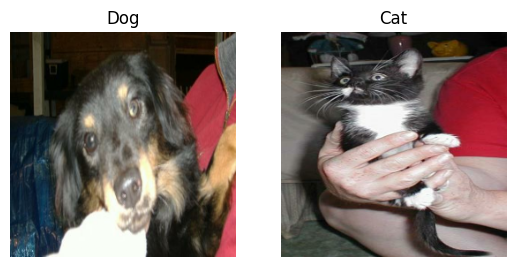

In [2]:
IMAGE_SIZE = (256, 256)


def get_tfrec_files(folder):
    """Get TFRecord files from a specified folder in the data directory."""
    files = tf.io.gfile.glob(os.path.join("data", folder, "*.tfrec"))
    print(f"{folder.capitalize()} TFRecord Files: {len(files)}")
    return files


def process_image(image_bytes):
    """Decode and preprocess an image from raw bytes."""
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return image


def parse_record(record):
    """Parse a single TFRecord example."""
    features = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    parsed = tf.io.parse_single_example(record, features)
    return process_image(parsed["image"])


def build_dataset(files, batch_size=8):
    """Create a batched dataset from a list of TFRecord files."""
    ds = tf.data.TFRecordDataset(files)
    ds = ds.map(parse_record, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)


cat_files = get_tfrec_files("cat-tfrec")
dog_files = get_tfrec_files("dog-tfrec")

cat_ds = build_dataset(cat_files)
dog_ds = build_dataset(dog_files)

cat_sample = next(iter(cat_ds))[0]
dog_sample = next(iter(dog_ds))[0]

plt.subplot(121)
plt.title("Dog")
plt.axis("off")
plt.imshow(dog_sample * 0.5 + 0.5)

plt.subplot(122)
plt.title("Cat")
plt.axis("off")
plt.imshow(cat_sample * 0.5 + 0.5)
plt.show()

# Show sample images from each dataset


2025-03-02 09:57:57.214269: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-02 09:57:57.250994: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


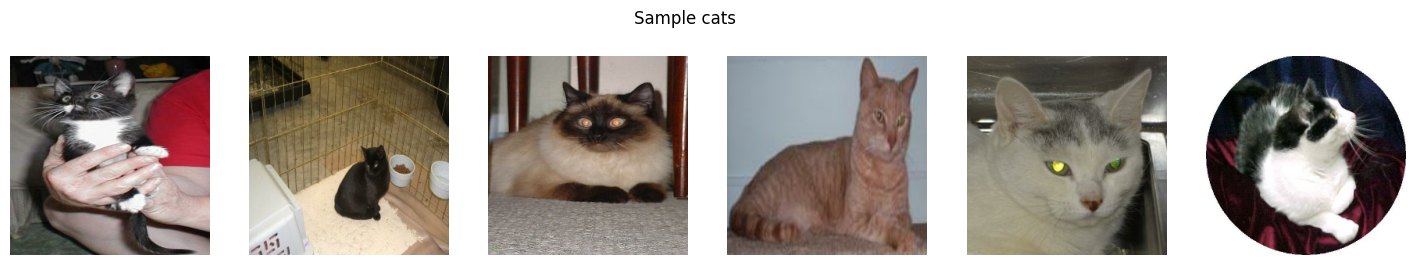

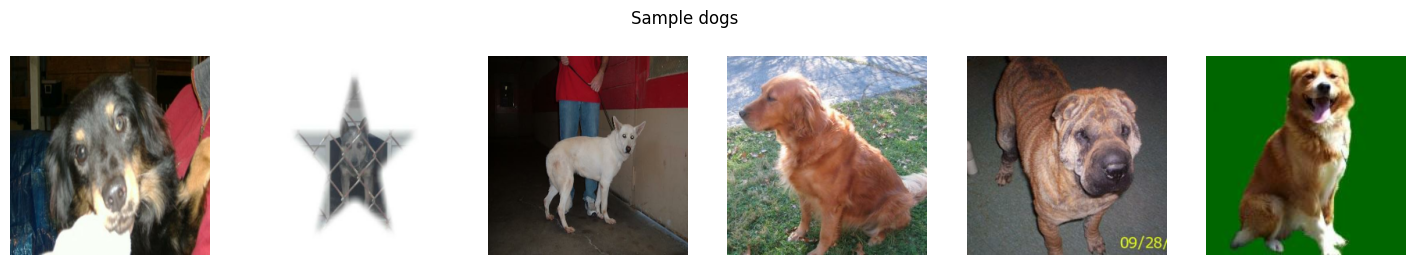

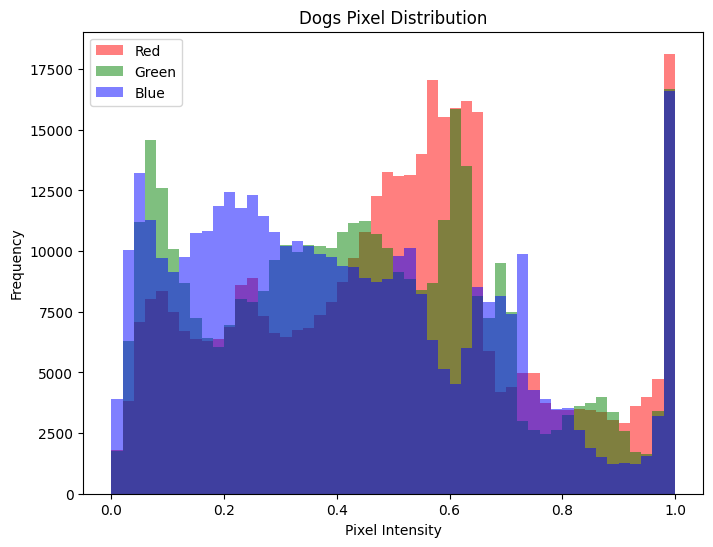

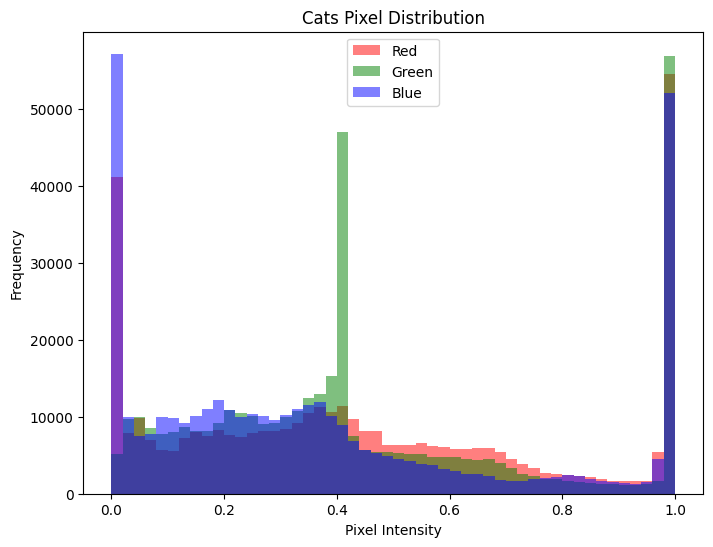

In [3]:
# Function to get a batch of images from a dataset
def get_sample_images(dataset, num_images=9):
    images = []
    for image in dataset.take(num_images):
        images.append(image[0].numpy())
    return np.array(images)


# Function to plot a grid of images
def plot_image_grid(images, title, grid_shape=(1, 6)):
    fig, axes = plt.subplots(
        grid_shape[0], grid_shape[1], figsize=(grid_shape[1] * 3, grid_shape[0] * 3)
    )
    fig.suptitle(title)
    for i, ax in enumerate(axes.flat):
        if i < images.shape[0]:
            # Convert pixel range from [-1,1] to [0,1] for display
            ax.imshow(images[i] * 0.5 + 0.5)
        ax.axis("off")
    plt.show()


# Function to plot per-channel histograms
def plot_channel_histograms(images, title):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    channels = ["Red", "Green", "Blue"]
    colors = ["r", "g", "b"]

    plt.figure(figsize=(8, 6))
    for i, color in enumerate(colors):
        channel_data = images[:, :, :, i].flatten()
        plt.hist(channel_data, bins=50, alpha=0.5, color=color, label=channels[i])
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


# Function to compute and print mean and standard deviation
def compute_stats(images):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    return mean, std


# Get sample images from each dataset
cat_samples = get_sample_images(cat_ds, num_images=6)
dog_samples = get_sample_images(dog_ds, num_images=6)

# Plot image grids
plot_image_grid(cat_samples, "Sample cats")
plot_image_grid(dog_samples, "Sample dogs")

# Plot channel histograms
plot_channel_histograms(cat_samples, "Dogs Pixel Distribution")
plot_channel_histograms(dog_samples, "Cats Pixel Distribution")

# EDA


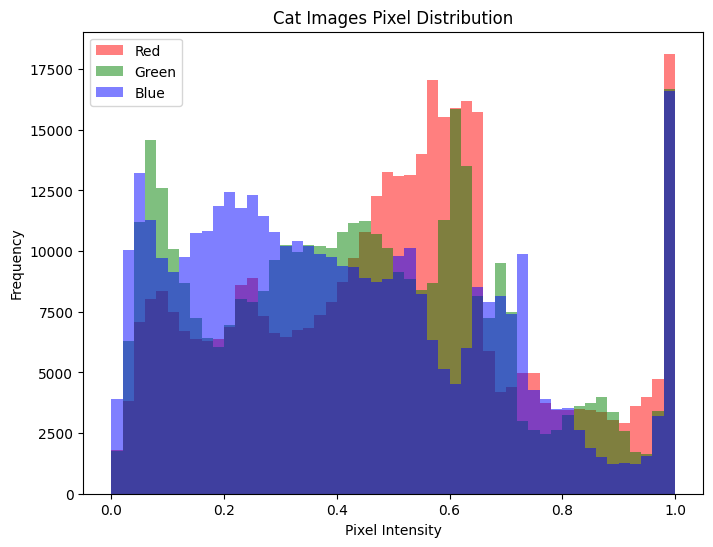

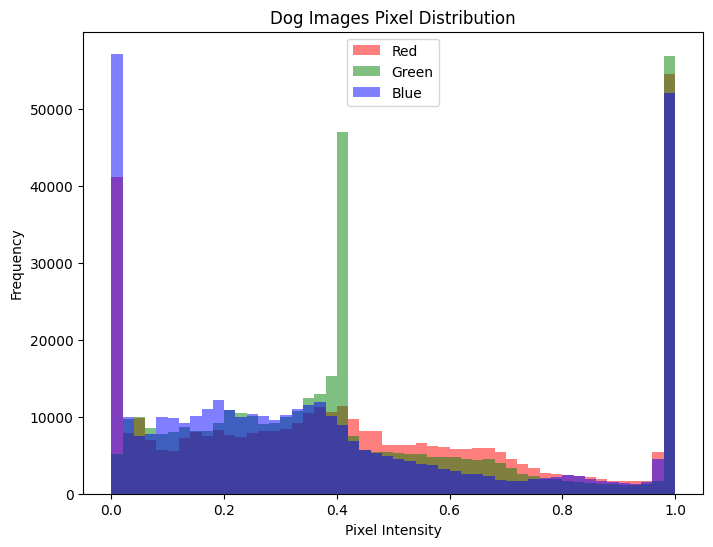

In [4]:
# Function to plot per-channel histograms
def plot_channel_histograms(images, title):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    channels = ["Red", "Green", "Blue"]
    colors = ["r", "g", "b"]

    plt.figure(figsize=(8, 6))
    for i, color in enumerate(colors):
        channel_data = images[:, :, :, i].flatten()
        plt.hist(channel_data, bins=50, alpha=0.5, color=color, label=channels[i])
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


# Function to compute and print mean and standard deviation
def compute_stats(images):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    return mean, std


# Plot channel histograms
plot_channel_histograms(cat_samples, "Cat Images Pixel Distribution")
plot_channel_histograms(dog_samples, "Dog Images Pixel Distribution")

Cat JPG Files: 12405
Dog JPG Files: 12364


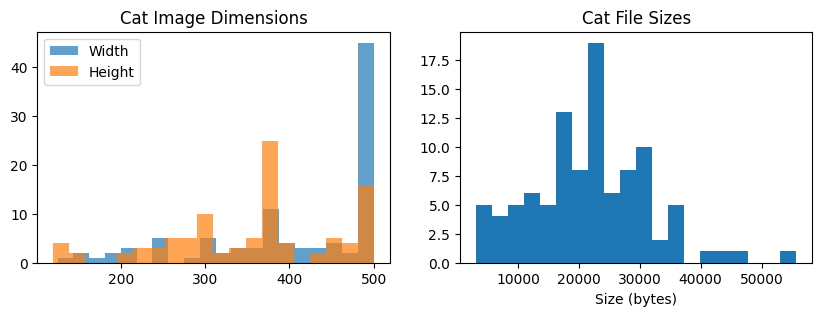

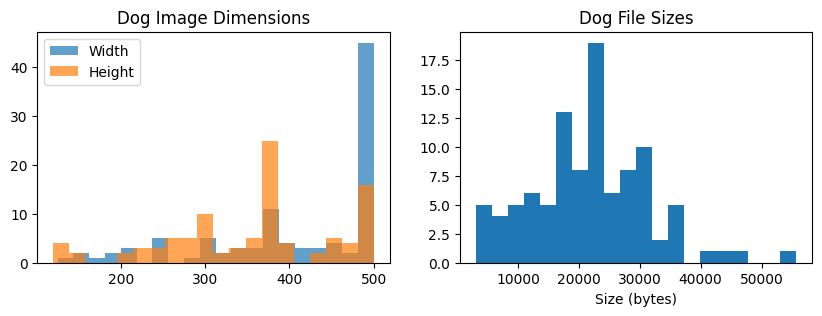

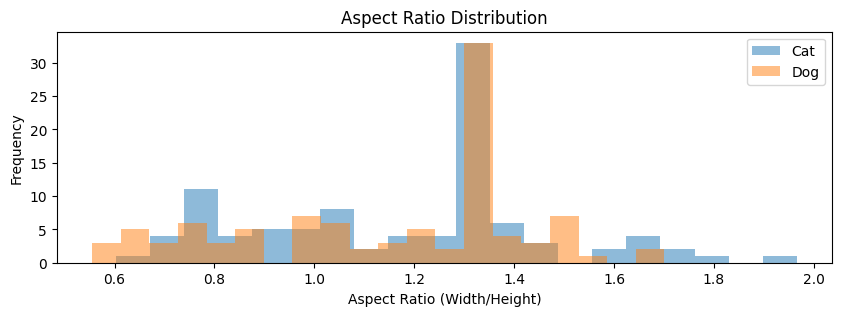

In [5]:
def get_jpg_files(folder):
    """Get JPG files from a specified folder in the data directory."""
    files = tf.io.gfile.glob(os.path.join("data", folder, "*.jpg"))
    print(f"{folder.capitalize()} JPG Files: {len(files)}")
    return files

def dataset_summary(files, folder):
    image_sizes = []
    file_sizes = []

    for file in files[:100]:  # Sample for speed
        with Image.open(file) as img:
            image_sizes.append(img.size)
            file_sizes.append(os.path.getsize(file))

    # Plot image dimension distributions and file size distribution
    widths, heights = zip(*image_sizes)
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].hist(widths, bins=20, alpha=0.7, label="Width")
    axes[0].hist(heights, bins=20, alpha=0.7, label="Height")
    axes[0].legend()
    axes[0].set_title(f"{folder} Image Dimensions")

    axes[1].hist(file_sizes, bins=20)
    axes[1].set_title(f"{folder} File Sizes")
    axes[1].set_xlabel("Size (bytes)")
    plt.show()

cat_jpg_files = get_jpg_files("Cat")
dog_jpg_files = get_jpg_files("Dog")

dataset_summary(cat_jpg_files, "Cat")
dataset_summary(cat_jpg_files, "Dog")


def aspect_ratio_analysis(files, folder):
    ratios = []
    for file in files[:100]:
        with Image.open(file) as img:
            width, height = img.size
            ratios.append(width / height)
    return ratios


cat_ratios = aspect_ratio_analysis(cat_jpg_files, "Cat")
dog_ratios = aspect_ratio_analysis(dog_jpg_files, "Dog")

plt.figure(figsize=(10, 3))
plt.hist(cat_ratios, bins=20, alpha=0.5, label="Cat")
plt.hist(dog_ratios, bins=20, alpha=0.5, label="Dog")
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# CycleGAN

## Generator

## Discriminator

## Loss functions

In [6]:
class Downsample(layers.Layer):
    def __init__(self, filters, size, apply_instancenorm=True, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            use_bias=False,
        )
        self.norm = (
            tf.keras.layers.GroupNormalization(
                gamma_initializer=keras.initializers.RandomNormal(
                    mean=0.0, stddev=0.02
                ),
                groups=-1,
            )
            if apply_instancenorm
            else None
        )
        self.activation = layers.LeakyReLU()

    def call(self, inputs):
        x = self.conv(inputs)
        if self.norm:
            x = self.norm(x)
        return self.activation(x)


class Upsample(layers.Layer):
    def __init__(self, filters, size, apply_dropout=False, **kwargs):
        super().__init__(**kwargs)
        self.conv_transpose = layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            use_bias=False,
        )
        self.norm = tf.keras.layers.GroupNormalization(
            gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
            groups=-1,
        )
        self.dropout = layers.Dropout(0.5) if apply_dropout else None
        self.activation = layers.ReLU()

    def call(self, inputs, training=False):
        x = self.conv_transpose(inputs)
        x = self.norm(x)
        if self.dropout:
            x = self.dropout(x, training=training)
        return self.activation(x)


class Generator(keras.Model):
    def __init__(self, output_channels=3, **kwargs):
        super().__init__(**kwargs)
        self.down_stack = [
            Downsample(64, 4, apply_instancenorm=False),
            Downsample(128, 4),
            Downsample(256, 4),
            Downsample(512, 4),
            Downsample(512, 4),
            Downsample(512, 4),
            Downsample(512, 4),
            Downsample(512, 4),
        ]

        self.up_stack = [
            Upsample(512, 4, apply_dropout=True),
            Upsample(512, 4, apply_dropout=True),
            Upsample(512, 4, apply_dropout=True),
            Upsample(512, 4),
            Upsample(256, 4),
            Upsample(128, 4),
            Upsample(64, 4),
        ]

        self.last_conv = layers.Conv2DTranspose(
            output_channels,
            4,
            strides=2,
            padding="same",
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            activation="tanh",
        )
        self.concat = layers.Concatenate()

    def call(self, inputs, training=False):
        x = inputs
        skips = []
        for down in self.down_stack:
            x = down(x, training=training)
            skips.append(x)
        # Remove the bottleneck output and reverse the skip connections
        skips = list(reversed(skips[:-1]))
        for up, skip in zip(self.up_stack, skips):
            x = up(x, training=training)
            x = self.concat([x, skip])
        return self.last_conv(x)

In [7]:
class Discriminator(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        initializer = tf.random_normal_initializer(0.0, 0.02)
        gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

        self.down1 = Downsample(64, 4, apply_instancenorm=False)
        self.down2 = Downsample(128, 4)
        self.down3 = Downsample(256, 4)
        self.zero_pad1 = layers.ZeroPadding2D()
        self.conv = layers.Conv2D(
            512, 4, strides=1, kernel_initializer=initializer, use_bias=False
        )
        self.norm1 = layers.GroupNormalization(gamma_initializer=gamma_init, groups=-1)
        self.leaky_relu = layers.LeakyReLU()
        self.zero_pad2 = layers.ZeroPadding2D()
        self.last_conv = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)

    def call(self, inputs, training=False):
        x = self.down1(inputs, training=training)
        x = self.down2(x, training=training)
        x = self.down3(x, training=training)
        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.norm1(x)
        x = self.leaky_relu(x)
        x = self.zero_pad2(x)
        return self.last_conv(x)


with strategy.scope():
    cat_generator = Generator()  # transforms dogs to cats
    dog_generator = Generator()  # transforms cats to dogs
    cat_discriminator = Discriminator()  # differentiates dogs vs. generated cats
    dog_discriminator = Discriminator()  # differentiates cats vs. generated dogs

In [8]:
class CycleGan(keras.Model):
    def __init__(
        self, cat_gen, dog_gen, cat_disc, dog_disc, lambda_cycle=10, **kwargs
    ):
        super().__init__(**kwargs)
        self.m_gen = cat_gen
        self.p_gen = dog_gen
        self.m_disc = cat_disc
        self.p_disc = dog_disc
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
        **kwargs
    ):
        super().compile(**kwargs)
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def compute_losses(self, real_cat, real_dog):
        # Generate fake images and their cycles
        fake_cat = self.m_gen(real_dog, training=True)
        cycled_dog = self.p_gen(fake_cat, training=True)
        fake_dog = self.p_gen(real_cat, training=True)
        cycled_cat = self.m_gen(fake_dog, training=True)

        # Identity mappings
        same_cat = self.m_gen(real_cat, training=True)
        same_dog = self.p_gen(real_dog, training=True)

        # Discriminator evaluations
        disc_real_cat = self.m_disc(real_cat, training=True)
        disc_fake_cat = self.m_disc(fake_cat, training=True)
        disc_real_dog = self.p_disc(real_dog, training=True)
        disc_fake_dog = self.p_disc(fake_dog, training=True)

        # Generator losses
        cat_gen_loss = self.gen_loss_fn(disc_fake_cat)
        dog_gen_loss = self.gen_loss_fn(disc_fake_dog)

        cycle_loss = self.cycle_loss_fn(
            real_cat, cycled_cat, self.lambda_cycle
        ) + self.cycle_loss_fn(real_dog, cycled_dog, self.lambda_cycle)

        id_loss_cat = self.identity_loss_fn(real_cat, same_cat, self.lambda_cycle)
        id_loss_dog = self.identity_loss_fn(real_dog, same_dog, self.lambda_cycle)

        total_cat_gen_loss = cat_gen_loss + cycle_loss + id_loss_cat
        total_dog_gen_loss = dog_gen_loss + cycle_loss + id_loss_dog

        # Discriminator losses
        cat_disc_loss = self.disc_loss_fn(disc_real_cat, disc_fake_cat)
        dog_disc_loss = self.disc_loss_fn(disc_real_dog, disc_fake_dog)

        return {
            "total_cat_gen_loss": total_cat_gen_loss,
            "total_dog_gen_loss": total_dog_gen_loss,
            "cat_disc_loss": cat_disc_loss,
            "dog_disc_loss": dog_disc_loss,
        }

    @tf.function
    def train_step(self, batch_data):
        real_cat, real_dog = batch_data

        with tf.GradientTape(persistent=True) as tape:
            losses = self.compute_losses(real_cat, real_dog)

        # Compute gradients for generators
        m_gen_grads = tape.gradient(
            losses["total_cat_gen_loss"], self.m_gen.trainable_variables
        )
        p_gen_grads = tape.gradient(
            losses["total_dog_gen_loss"], self.p_gen.trainable_variables
        )
        # Compute gradients for discriminators
        m_disc_grads = tape.gradient(
            losses["cat_disc_loss"], self.m_disc.trainable_variables
        )
        p_disc_grads = tape.gradient(
            losses["dog_disc_loss"], self.p_disc.trainable_variables
        )

        # Apply gradients
        self.m_gen_optimizer.apply_gradients(
            zip(m_gen_grads, self.m_gen.trainable_variables)
        )
        self.p_gen_optimizer.apply_gradients(
            zip(p_gen_grads, self.p_gen.trainable_variables)
        )
        self.m_disc_optimizer.apply_gradients(
            zip(m_disc_grads, self.m_disc.trainable_variables)
        )
        self.p_disc_optimizer.apply_gradients(
            zip(p_disc_grads, self.p_disc.trainable_variables)
        )

        return {
            "cat_gen_loss": losses["total_cat_gen_loss"],
            "dog_gen_loss": losses["total_dog_gen_loss"],
            "cat_disc_loss": losses["cat_disc_loss"],
            "dog_disc_loss": losses["dog_disc_loss"],
        }

In [9]:
class CycleGanLosses:
    @staticmethod
    def discriminator_loss(real, generated):
        bce = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE
        )
        real_loss = bce(tf.ones_like(real), real)
        generated_loss = bce(tf.zeros_like(generated), generated)
        return 0.5 * (real_loss + generated_loss)

    @staticmethod
    def generator_loss(generated):
        bce = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE
        )
        return bce(tf.ones_like(generated), generated)

    @staticmethod
    def cycle_loss(real_image, cycled_image, lambda_cycle):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return lambda_cycle * loss

    @staticmethod
    def identity_loss(real_image, same_image, lambda_cycle):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return lambda_cycle * 0.5 * loss

# Initial Training

In [10]:
with strategy.scope():
    # Configure optimizers with shared settings
    optimizer_config = {"learning_rate": 2e-4, "beta_1": 0.5}
    cat_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    dog_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    cat_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    dog_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)

    # Instantiate and compile the CycleGAN model using the new loss functions
    cycle_gan_model = CycleGan(
        cat_generator, dog_generator, cat_discriminator, dog_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer=cat_generator_optimizer,
        p_gen_optimizer=dog_generator_optimizer,
        m_disc_optimizer=cat_discriminator_optimizer,
        p_disc_optimizer=dog_discriminator_optimizer,
        gen_loss_fn=CycleGanLosses.generator_loss,
        disc_loss_fn=CycleGanLosses.discriminator_loss,
        cycle_loss_fn=CycleGanLosses.cycle_loss,
        identity_loss_fn=CycleGanLosses.identity_loss,
    )

cycle_gan_model.fit(tf.data.Dataset.zip((cat_ds, dog_ds)), epochs=1)

I0000 00:00:1740934703.857133    1171 service.cc:148] XLA service 0x7fbd340031c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740934703.861560    1171 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-03-02 09:58:24.568848: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740934708.062755    1171 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-03-02 09:58:58.321197: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1740934738.910921    1171 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1545/1545 ━━━━━━━━━━━━━━━━━━━━ 379s 207ms/step - cat_disc_loss: 0.6478 - cat_gen_loss: 3.1536 - dog_disc_loss: 0.6189 - dog_gen_loss: 3.2668


2025-03-02 10:04:18.426602: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-03-02 10:04:18.426653: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7393648595751740107
/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


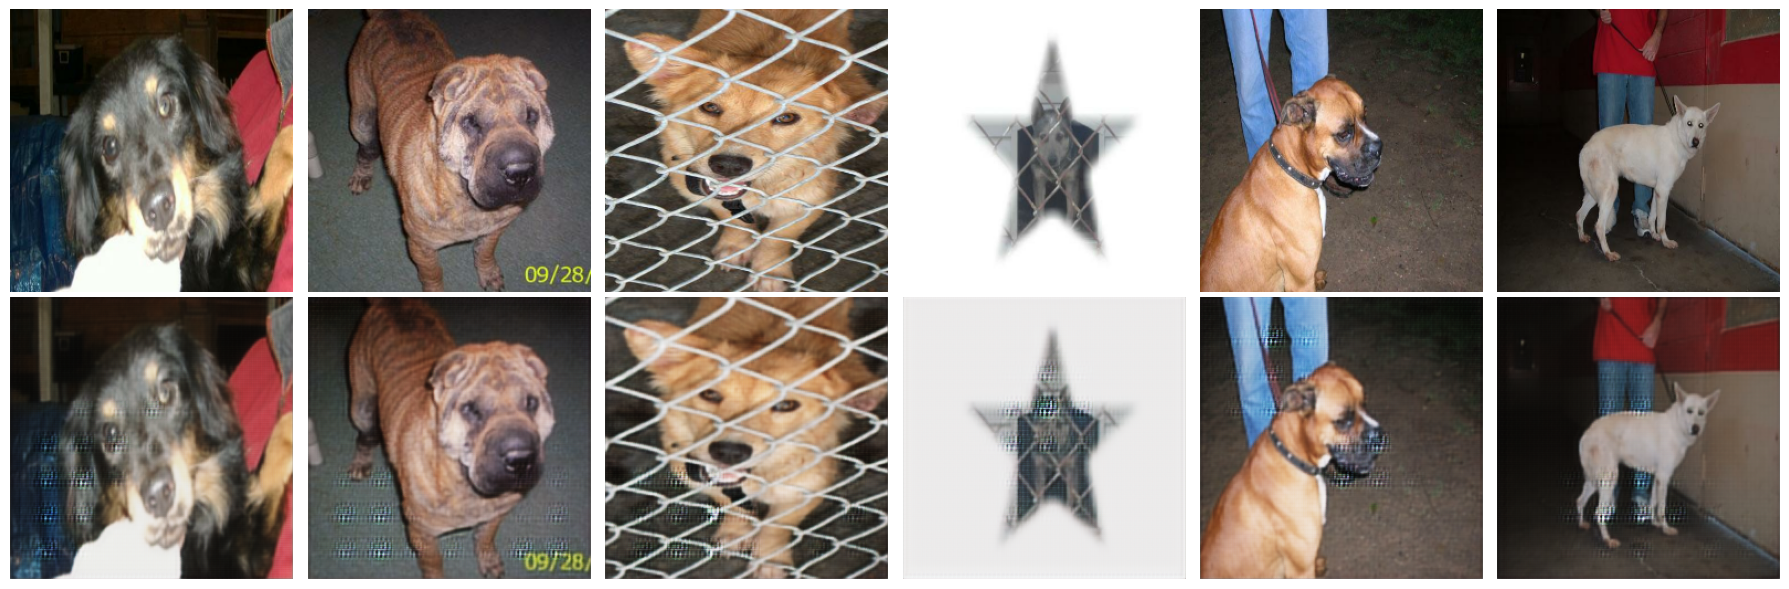

In [11]:
def generate_images():
    fig, ax = plt.subplots(2, 6, figsize=(18, 6))
    for i, img in enumerate(dog_ds.shuffle(10).take(6)):
        original = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        transformed = cat_generator(img, training=False)[0].numpy()
        transformed = (transformed * 127.5 + 127.5).astype(np.uint8)

        ax[0, i].imshow(original)
        ax[0, i].axis("off")
        ax[1, i].imshow(transformed)
        ax[1, i].axis("off")

    ax[0, 0].set_ylabel("Input Dog Photos", fontsize=14)
    ax[1, 0].set_ylabel("Cat Transformations", fontsize=14)
    plt.tight_layout()
    plt.show()

generate_images()

# Hyperparam Tuning

In [ ]:
def objective(trial):
    try:
        # Define hyperparameters
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        beta_1 = trial.suggest_float("beta_1", 0.0, 0.9)
        lambda_cycle = trial.suggest_float("lambda_cycle", 5, 15)
        epochs = 1

        # Configure optimizers
        optimizer_config = {"learning_rate": learning_rate, "beta_1": beta_1}
        cat_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
        dog_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
        cat_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
        dog_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)

        # Instantiate and compile model
        with strategy.scope():
            cycle_gan_model = CycleGan(
                cat_generator,
                dog_generator,
                cat_discriminator,
                dog_discriminator,
                lambda_cycle=lambda_cycle,
            )

            cycle_gan_model.compile(
                m_gen_optimizer=cat_generator_optimizer,
                p_gen_optimizer=dog_generator_optimizer,
                m_disc_optimizer=cat_discriminator_optimizer,
                p_disc_optimizer=dog_discriminator_optimizer,
                gen_loss_fn=CycleGanLosses.generator_loss,
                disc_loss_fn=CycleGanLosses.discriminator_loss,
                cycle_loss_fn=CycleGanLosses.cycle_loss,
                identity_loss_fn=CycleGanLosses.identity_loss,
            )

        # Train the model
        history = cycle_gan_model.fit(
            tf.data.Dataset.zip((cat_ds, dog_ds)),
            epochs=epochs,
        )

        # Extract loss - handle potential non-scalar values
        cat_gen_losses = history.history["cat_gen_loss"]
        if isinstance(cat_gen_losses, (list, np.ndarray)):
            loss = float(np.mean(cat_gen_losses))
        else:
            loss = float(cat_gen_losses)

        # Validate loss
        if not np.isfinite(loss):
            raise ValueError("Loss value is not finite")

        print(f"Trial completed with loss: {loss}")
        return loss

    except Exception as e:
        print(f"Trial failed with error: {str(e)}")
        raise optuna.exceptions.TrialPruned()


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print("Best hyperparameters: ", study.best_params)

# 1 trial
# Best hyperparameters:  {'learning_rate': 2.7262211174438973e-05, 'beta_1': 0.16874939882380008, 'lambda_cycle': 12.720006238095113}
# 5 trials
# Best hyperparameters:  {'learning_rate': 0.0002793447590688152, 'beta_1': 0.5014848894861316, 'lambda_cycle': 8.945432168241094}

[I 2025-03-02 10:04:20,729] A new study created in memory with name: no-name-c829ecc6-52b3-43a6-ab98-9b089686062b
2025-03-02 10:05:04.420708: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 8 bytes spill stores, 8 bytes spill loads



1545/1545 ━━━━━━━━━━━━━━━━━━━━ 356s 202ms/step - cat_disc_loss: 0.6616 - cat_gen_loss: 2.8553 - dog_disc_loss: 0.6174 - dog_gen_loss: 3.0861


2025-03-02 10:10:16.906949: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9357376193635459198
[I 2025-03-02 10:10:16,924] Trial 0 finished with value: 2.3575639724731445 and parameters: {'learning_rate': 0.0002240062074139713, 'beta_1': 0.8989979325852782, 'lambda_cycle': 14.085904806621466}. Best is trial 0 with value: 2.3575639724731445.


Trial completed with loss: 2.3575639724731445


2025-03-02 10:11:02.973329: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 8 bytes spill stores, 8 bytes spill loads



1545/1545 ━━━━━━━━━━━━━━━━━━━━ 365s 206ms/step - cat_disc_loss: 0.6588 - cat_gen_loss: 2.3574 - dog_disc_loss: 0.6673 - dog_gen_loss: 2.3829


2025-03-02 10:16:21.463289: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
[I 2025-03-02 10:16:21,483] Trial 1 finished with value: 1.9751031398773193 and parameters: {'learning_rate': 0.0002335643967783478, 'beta_1': 0.2987138492031855, 'lambda_cycle': 14.489911318157255}. Best is trial 1 with value: 1.9751031398773193.


Trial completed with loss: 1.9751031398773193


2025-03-02 10:17:09.262371: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 8 bytes spill stores, 8 bytes spill loads



1545/1545 ━━━━━━━━━━━━━━━━━━━━ 367s 206ms/step - cat_disc_loss: 0.6633 - cat_gen_loss: 1.6073 - dog_disc_loss: 0.6606 - dog_gen_loss: 1.6250


[I 2025-03-02 10:22:28,471] Trial 2 finished with value: 1.3582993745803833 and parameters: {'learning_rate': 0.0002793447590688152, 'beta_1': 0.5014848894861316, 'lambda_cycle': 8.945432168241094}. Best is trial 2 with value: 1.3582993745803833.


Trial completed with loss: 1.3582993745803833


2025-03-02 10:23:12.827564: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 8 bytes spill stores, 8 bytes spill loads



1545/1545 ━━━━━━━━━━━━━━━━━━━━ 363s 206ms/step - cat_disc_loss: 0.6526 - cat_gen_loss: 2.1411 - dog_disc_loss: 0.6453 - dog_gen_loss: 2.1651


[I 2025-03-02 10:28:31,671] Trial 3 finished with value: 1.8878726959228516 and parameters: {'learning_rate': 0.0003757250181790442, 'beta_1': 0.16440195567563662, 'lambda_cycle': 14.788988627043363}. Best is trial 2 with value: 1.3582993745803833.


Trial completed with loss: 1.8878726959228516


2025-03-02 10:29:17.321271: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 8 bytes spill stores, 8 bytes spill loads



1545/1545 ━━━━━━━━━━━━━━━━━━━━ 364s 206ms/step - cat_disc_loss: 0.6464 - cat_gen_loss: 1.7562 - dog_disc_loss: 0.6376 - dog_gen_loss: 1.7745


[I 2025-03-02 10:34:35,711] Trial 4 finished with value: 1.5050657987594604 and parameters: {'learning_rate': 0.00014240987680082368, 'beta_1': 0.6034314682981701, 'lambda_cycle': 12.46315615504459}. Best is trial 2 with value: 1.3582993745803833.


Trial completed with loss: 1.5050657987594604
Best hyperparameters:  {'learning_rate': 0.0002793447590688152, 'beta_1': 0.5014848894861316, 'lambda_cycle': 8.945432168241094}


In [14]:
with strategy.scope():
    # Use best hyperparameters from Optuna
    learning_rate = study.best_params["learning_rate"]
    beta_1 = study.best_params["beta_1"]
    lambda_cycle = study.best_params["lambda_cycle"]

    # Configure optimizers
    optimizer_config = {"learning_rate": learning_rate, "beta_1": beta_1}
    cat_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    dog_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    cat_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    dog_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)

    # Instantiate and compile model
    with strategy.scope():
        cycle_gan_model = CycleGan(
            cat_generator,
            dog_generator,
            cat_discriminator,
            dog_discriminator,
            lambda_cycle=lambda_cycle,
        )

        cycle_gan_model.compile(
            m_gen_optimizer=cat_generator_optimizer,
            p_gen_optimizer=dog_generator_optimizer,
            m_disc_optimizer=cat_discriminator_optimizer,
            p_disc_optimizer=dog_discriminator_optimizer,
            gen_loss_fn=CycleGanLosses.generator_loss,
            disc_loss_fn=CycleGanLosses.discriminator_loss,
            cycle_loss_fn=CycleGanLosses.cycle_loss,
            identity_loss_fn=CycleGanLosses.identity_loss,
        )

cycle_gan_model.fit(tf.data.Dataset.zip((cat_ds, dog_ds)), epochs=5)
generate_images()

Epoch 1/5


2025-03-02 13:43:40.542447: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 8 bytes spill stores, 8 bytes spill loads

2025-03-02 13:43:50.908984: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.79GiB (rounded to 2998212864)requested by op 
2025-03-02 13:43:50.909103: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2025-03-02 13:43:50.909121: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 1717, Chunks in use: 1717. 429.2KiB allocated for chunks. 429.2KiB in use in bin. 20.4KiB client-requested in use in bin.
2025-03-02 13:43:50.909129: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (512): 	Total Chunks: 158, Chunks in use: 158. 79.5KiB allocated for chunks. 79.5KiB in use in bin. 79.0KiB cl

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_939/4291879234.py", line 35, in <module>

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 2998212704 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_718340]